In [1]:
from bs4 import BeautifulSoup
from time import sleep
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from pymorphy3 import MorphAnalyzer

from collections import Counter
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryabo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryabo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ryabo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
def parsing_data(key_words, url):
    service = Service('chromedriver.exe')
    browser = Chrome(service = service)
    browser.get(url)
    first_settings = True

    for word in key_words:
        sleep(3)
        data = []
        input_row = browser.find_element(By.XPATH, '//*[@id="main"]/div/div/div/div[1]/form/div[1]/input')
        input_row.clear()
        input_row.send_keys(word)
        browser.find_element(By.XPATH, '//*[@id="main"]/div/div/div/div[1]/form/div[2]/button').click()
        sleep(2)
        browser.find_element(By.XPATH, '//*[@id="main"]/div/div[2]/div/div/div/div[1]/div/nav/ul/li[2]/button').click()     
        sleep(2)
        if first_settings:
            browser.find_element(By.XPATH, '//*[@id="main"]/div/div[2]/div/div/div/div[2]/ul/li[2]/span/button').click()
            sleep(1)
            input_cell = browser.find_element(By.XPATH, '/html/body/div[3]/div/div/div/div/div/div[2]/div[3]/div[2]/input')
            input_cell.clear()
            input_cell.send_keys(30)
            first_settings = False
            browser.find_element(By.XPATH, '//*[@id="paginationSettingsOverlay"]/div/div[3]/div/button[1]').click()
            sleep(2)

        while True:
            sleep(3)
            soup = BeautifulSoup(browser.page_source, 'lxml')
            sequences = soup.findAll('tr', class_ = 'snippet')
            for seq in sequences:
                data.append(seq.text.replace('\n\n\n\n\n\n\n\n\n\n\n\n\n', ''))

            try:
                browser.find_element(By.CSS_SELECTOR, '#main > div > div.results-page > div > div:nth-child(2) > div > div > div > div > div.col-12.col-md-9.col-lg-8 > div > ul > li.ant-pagination-next > button').click()
            except Exception:
                break

        col = pd.Series(data)
        print(len(col))
        col.to_csv(f'{word}.csv')
        print(f'По ключевому слову {word} данные сохранены в csv файл')
        browser.find_element(By.XPATH, '//*[@id="__nuxt"]/div[2]/header/div/div/div/a').click()

    browser.quit()
    return 'Парсинг завершен успешно'

In [3]:
key_words = ['игла', 'пара', 'лист', 'сетка', 'кора', 'точка', 'кость', 'свет', 'чаша', 'каток']

In [ ]:
url = 'https://ruscorpora.ru/'
parsing_data(key_words, url)

In [4]:
for word in key_words:
    print(word, ':', len(pd.read_csv(f'{word}.csv')))

игла : 4375
пара : 17010
лист : 20130
сетка : 6552
кора : 6635
точка : 45000
кость : 17804
свет : 26040
чаша : 7450
каток : 2121


In [5]:
stopwords = stopwords.words('russian')
morph = MorphAnalyzer()

In [6]:
custom_stopwords = ['который', 'это', 'ещё', 'очень', 'свой', 'стать', 'весь', 'каждый', 'мочь', 'всё', 'попасть', 'оказаться', 'ходить',
                    'поставить', 'положить', 'сторона', 'вместо', 'должный', 'любой', 'некоторый', 'остаться', 'большой', 'появиться', 'самый',
                   'лишь', 'назад', 'эт', 'видеть', 'правда', 'найти', 'прямо', 'спросить', 'наш', 'ран', 'например', 'первый', 'оно', 'также',
                   'возле', 'словно', 'просто', 'именно', 'каткий', 're', 'пзрк', 'несколько', 'среда', 'сказать', 'иметь', 'сегодня',
                   'написать', 'тридцать', 'сто', 'склоняться', 'переполняться', 'переполнять', 'мухин', 'версия', 'поэтому', 'съ', 'изъ', 'какъ', 
                    'итак', 'iii', 'тыс']
stopwords += custom_stopwords

In [7]:
def preprocessing(text):
    tokens = word_tokenize(str(text).lower())
    lemmas = []
    for token in tokens:
        if token.isalpha() and len(token) > 2:
            parsed_word = morph.parse(token)[0]
            lemma = parsed_word.normal_form
            if lemma not in stopwords:
                if lemma == 'каткомъ':
                    lemma = 'каток'
                lemmas.append(lemma)
    return lemmas

In [8]:
def get_counters_and_pre_data(df):
    single_counter = Counter()
    pair_counter = Counter()
    key_word = df.columns[0]

    preprocessing_data = df[key_word].apply(preprocessing)

    for seq in preprocessing_data:
        single_counter.update(seq)
        pairs = combinations([word for word in seq], 2)
        for pair in pairs:
            if pair[0] == f'{key_word}' or pair[1] == f'{key_word}':
                if pair[1] != f'{key_word}':
                    pair = (pair[1], pair[0])
                pair_counter[pair] += 1

    return single_counter, pair_counter, preprocessing_data

In [9]:
def get_counters_and_pre_data_all_pairs(df):
    single_counter = Counter()
    pair_counter = Counter()
    key_word = df.columns[0]

    preprocessing_data = df[key_word].apply(preprocessing)

    for seq in preprocessing_data:
        single_counter.update(seq)
        pairs = combinations([word for word in seq], 2)
        for pair in pairs:
            pair_counter[pair] += 1

    return single_counter, pair_counter, preprocessing_data

In [10]:
def get_counters_and_pre_data_bigrams(df):
    single_counter = Counter()
    pair_counter = Counter()
    key_word = df.columns[0]

    preprocessing_data = df[key_word].apply(preprocessing)

    for seq in preprocessing_data:
        single_counter.update(seq)
        bigrams = ngrams(seq, 2)
        for bigram in bigrams:
            pair_counter[bigram] += 1

    return single_counter, pair_counter, preprocessing_data

In [11]:
def get_df(key_word):
    df = pd.read_csv(f'{key_word}.csv').drop(columns = ['Unnamed: 0'])
    df.columns = [key_word]
    return df

In [12]:
def show_pmi(pair_counter, single_counter, min_count = 5):
    result = []
    sum_pair_counts = sum(pair_counter.values())
    sum_single_word = sum(single_counter.values())
    for pair, count in pair_counter.items():
        if count >= min_count:
            p_ab = count / sum_pair_counts
            a, b = pair
            count_a = single_counter.get(a, 0)
            count_b = single_counter.get(b, 0)
            p_a = count_a / sum_single_word
            p_b = count_b / sum_single_word
            pmi = np.log2(p_ab / (p_a * p_b))

            if pmi >= 3:
                result.append(' '.join(pair))
                print(f'pmi = {pmi:.2f} у пары {pair} : {count}')
    print('\n')
    return result

In [13]:
def get_pairs_from_documents(preprocessing_data):# window_size по умолчанию 2 для finder
    finder = BigramCollocationFinder.from_documents(preprocessing_data)
    finder.apply_freq_filter(5)
    finder.apply_ngram_filter(lambda w1, w2: finder.score_ngram(bam.pmi, w1, w2) < 1)
    filtered_pairs_pmi = finder.score_ngrams(bam.pmi)
    return filtered_pairs_pmi

In [14]:
def get_pairs_from_words(preprocessing_data):
    all_words = []
    for phrase in preprocessing_data:
        all_words.extend(phrase)
    
    # window_size можем настроить уже при методе from_words, min = 2
    finder = BigramCollocationFinder.from_words(all_words, window_size=3)
    finder.apply_freq_filter(5)
    finder.apply_ngram_filter(lambda w1, w2: finder.score_ngram(bam.pmi, w1, w2) < 1)
    filtered_pairs_pmi = finder.score_ngrams(bam.pmi)
    return filtered_pairs_pmi

In [15]:
def get_data_for_model_from_finder(filtered_pairs_pmi):
    result = []
    for item in filtered_pairs_pmi:
        result.append(item[0][0] + ' ' + item[0][1])
    return result

In [16]:
def get_inetrias(vectors, key_word = ''):
    inetrias = {}
    for k in range(2, 18):
        k_means_iterations = {}
        for i in range(20):
            kmeans = KMeans(n_clusters = k)
            kmeans.fit(vectors)
            k_means_iterations[kmeans] = kmeans.inertia_
    
        best_iteration = min(k_means_iterations, key = k_means_iterations.get)
        inetrias[best_iteration] = best_iteration.inertia_
        
    plt.plot(range(2, 18), inetrias.values())
    plt.ylabel('Инерция (расстояние в кластере)')
    plt.xlabel('Количество кластеров')
    plt.title('Выбор количества кластеров')
    plt.savefig(f'kmeans_{key_word}.png', dpi=300)
    plt.show()
    plt.close()

    return inetrias

In [17]:
def get_silhouette_score(inetrias, n_kluster, vectors):
    best_model = list(inetrias.keys())[n_kluster-2]
    labels = best_model.predict(vectors)
    sil_score = silhouette_score(vectors, labels)
    return sil_score

In [18]:
def louvain(vectors, key_word=''):

    similarity = cosine_similarity(vectors)
    np.fill_diagonal(similarity, 0)
    G = nx.from_numpy_array(similarity)
    
    partition = community_louvain.best_partition(G)
    n_communities = len(set(partition.values()))
    
    cmap = plt.cm.Set1
    node_colors = [cmap(partition[node]) for node in G.nodes()]
    
    intra_edges = [(a,b) for a, b in G.edges() if partition[a] == partition[b]]
    
    plt.figure(figsize=(12, 12))
    
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Set1, node_size=20)
    nx.draw_networkx_edges(G, pos, edgelist=intra_edges, alpha=0.2)
    
    plt.title(f'Графовая кластеризация Louvain: {key_word}')
    plt.savefig(f'louvain_{key_word}.png', dpi=300)
    plt.show()
    plt.close()

    return np.array(list(partition.values()))

In [19]:
def lda(preprocessing_data):
    dictionary = Dictionary(preprocessing_data)
    corpus = [dictionary.doc2bow(phrase) for phrase in preprocessing_data]
    results = []
    best_model = None
    best_score = -float('inf')
    
    for num_topics in range(4, 12):
        lda = LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics)
        coherence_model = CoherenceModel(model = lda, texts=preprocessing_data, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        results.append(coherence_model.get_coherence())
        if coherence > best_score:
            best_score = coherence
            best_model = lda

    return results, best_model, corpus

In [20]:
def cycle_by_key_words(key_words, model, *, method = 'bigram', prerpocessing = False, pmi_handled = False, n_clusters = 5):
    for key_word in key_words:
        df = get_df(key_word)
        print(f'Анализируем корпус фраз по ключевому слову : {key_word}\n')
        
        if prerpocessing:
            if method == 'bigram':
                single_counter, pair_counter, preprocessing_data = get_counters_and_pre_data_bigrams(df)
            elif method == 'all':
                single_counter, pair_counter, preprocessing_data = get_counters_and_pre_data_all_pairs(df)
            else:
                single_counter, pair_counter, preprocessing_data = get_counters_and_pre_data(df)

            if pmi_handled:
                data = show_pmi(pair_counter, single_counter)
            else:
                filtered_collocations = get_pairs_from_documents(preprocessing_data)
                data = get_data_for_model_from_finder(filtered_collocations)
                
        else:
            data = df.iloc[:,0]
            _, _, preprocessing_data = get_counters_and_pre_data(df)
        
        vectors = model.encode(data)

        inetrias = get_inetrias(vectors, key_word)
        silhouette_score_k_means = get_silhouette_score(inetrias, n_clusters, vectors)
        print(f'Silhouette score, полученный с помощью кластеризации K-means = {silhouette_score_k_means:.3f}\n')

        labels = louvain(vectors, key_word)
        if len(set(labels)) > 1:
            silhouette_score_louvain = silhouette_score(vectors, labels)
            print(f'Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = {silhouette_score_louvain:.3f}\n')
    
            results, lda_model, corpus = lda(preprocessing_data)
            log_perplexity = lda_model.log_perplexity(corpus)
            print(f'Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = {log_perplexity:.3f}\n')
    
            print(f'Найденные моделью LDA скрытые темы:')
            for index, topic in lda_model.print_topics(-1):
                print(f'Тема {index} : {topic}')
            print('\n****\n')

In [21]:
bam = BigramAssocMeasures()
model_mpnet = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
model_dp = SentenceTransformer('DeepPavlov/rubert-base-cased-sentence')
model_tiny = SentenceTransformer('cointegrated/rubert-tiny2')

C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
No sentence-transformers model found with name DeepPavlov/rubert-base-cased-sentence. Creating a new one with mean pooling.


Анализируем корпус фраз по ключевому слову : игла



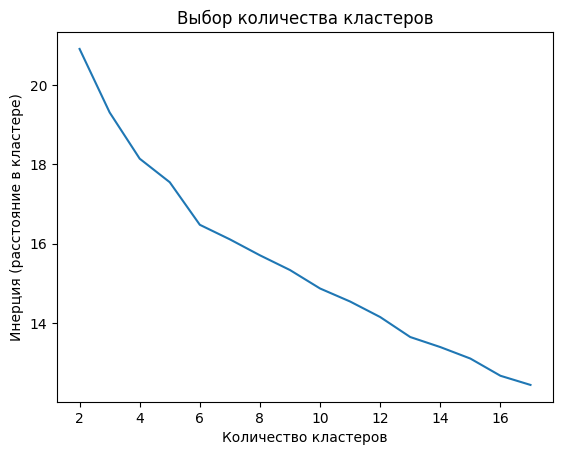

Silhouette score, полученный с помощью кластеризации K-means = 0.088



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


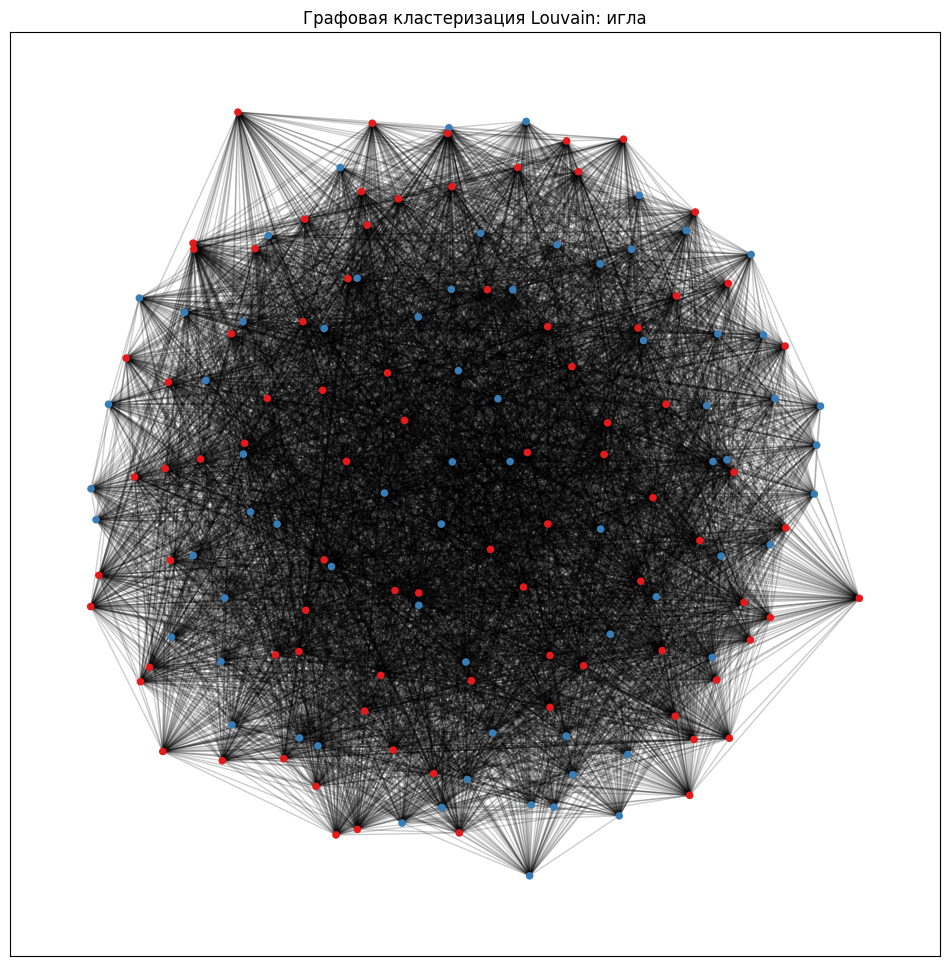

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.118

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -9.925

Найденные моделью LDA скрытые темы:
Тема 0 : 0.132*"игла" + 0.017*"множество" + 0.015*"работа" + 0.014*"булавка" + 0.013*"игра" + 0.011*"хотя" + 0.011*"крест" + 0.011*"колючий" + 0.010*"употреблять" + 0.010*"узор"
Тема 1 : 0.161*"игла" + 0.016*"острый" + 0.011*"пять" + 0.009*"сидеть" + 0.008*"составлять" + 0.008*"платок" + 0.008*"мозг" + 0.007*"адмиралтейский" + 0.007*"сердце" + 0.006*"терновый"
Тема 2 : 0.188*"игла" + 0.011*"нитка" + 0.008*"вперёд" + 0.008*"точно" + 0.007*"вонзаться" + 0.007*"колет" + 0.007*"случай" + 0.007*"стальной" + 0.006*"продевать" + 0.006*"детский"
Тема 3 : 0.060*"игла" + 0.014*"тысяча" + 0.014*"около" + 0.014*"день" + 0.011*"иголый" + 0.011*"корень" + 0.008*"пучок" + 0.008*"растение" + 0.007*"стекло" + 0.007*"больший"
Тема 4 : 0.170*"игла" + 0.022*"рука" + 0.013*"едва" + 0

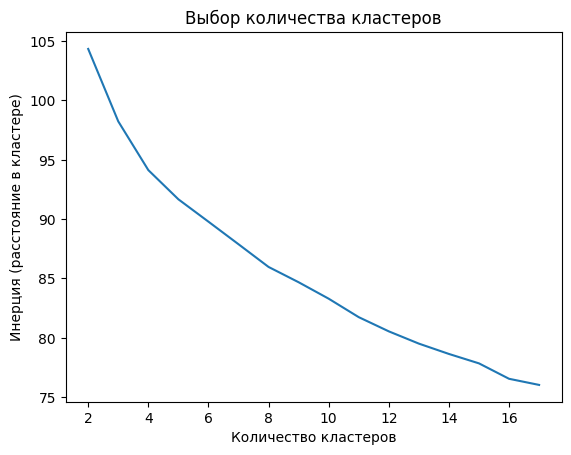

Silhouette score, полученный с помощью кластеризации K-means = 0.060



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


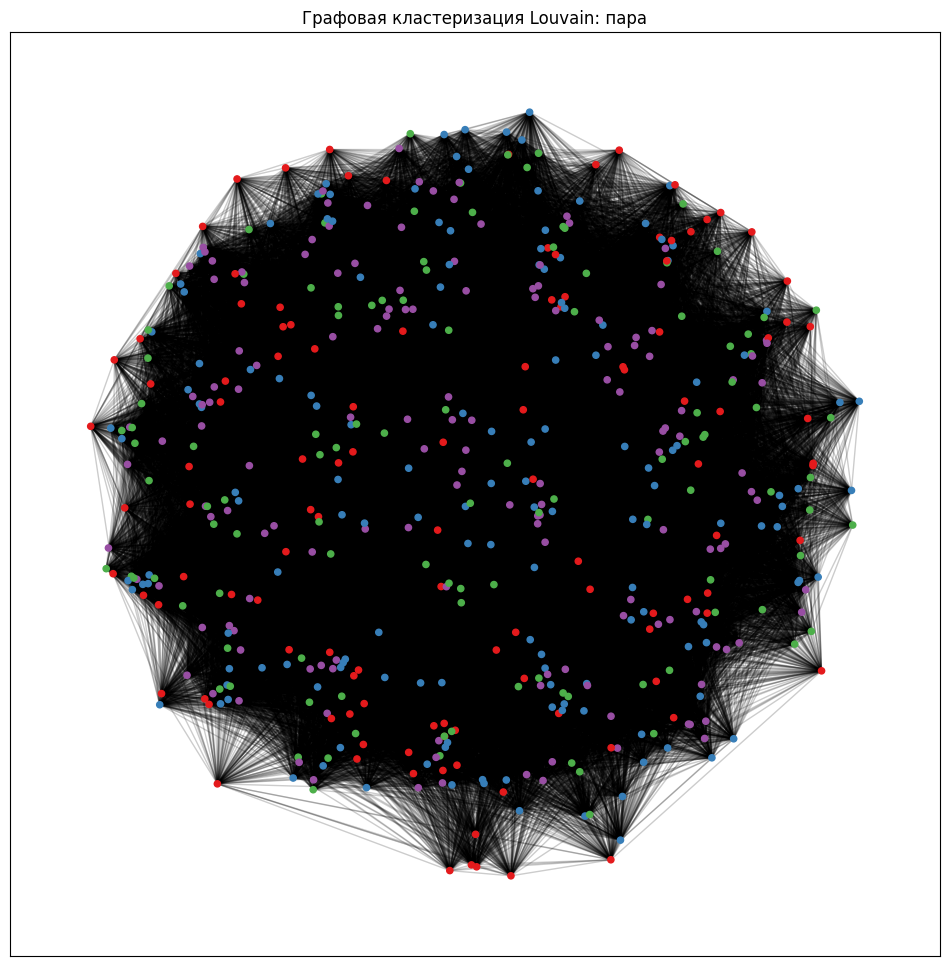

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.053

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -10.115

Найденные моделью LDA скрытые темы:
Тема 0 : 0.051*"пара" + 0.034*"сделать" + 0.022*"неделя" + 0.019*"метр" + 0.015*"номер" + 0.012*"яйцо" + 0.010*"вернуться" + 0.009*"потерять" + 0.009*"оставить" + 0.007*"россия"
Тема 1 : 0.255*"пара" + 0.059*"год" + 0.012*"месяц" + 0.010*"день" + 0.007*"десяток" + 0.006*"второй" + 0.006*"последний" + 0.005*"влюбить" + 0.005*"спустя" + 0.004*"пока"
Тема 2 : 0.197*"пара" + 0.027*"минута" + 0.014*"человек" + 0.010*"семейный" + 0.007*"пять" + 0.007*"молодой" + 0.007*"слово" + 0.007*"дверь" + 0.006*"случай" + 0.006*"час"
Тема 3 : 0.146*"пара" + 0.019*"молодой" + 0.012*"шесть" + 0.009*"казаться" + 0.008*"мужчина" + 0.008*"вполне" + 0.007*"размер" + 0.007*"праймер" + 0.006*"составить" + 0.006*"чистый"
Тема 4 : 0.084*"пара" + 0.024*"бутылка" + 0.019*"играть" + 0.018*"ме

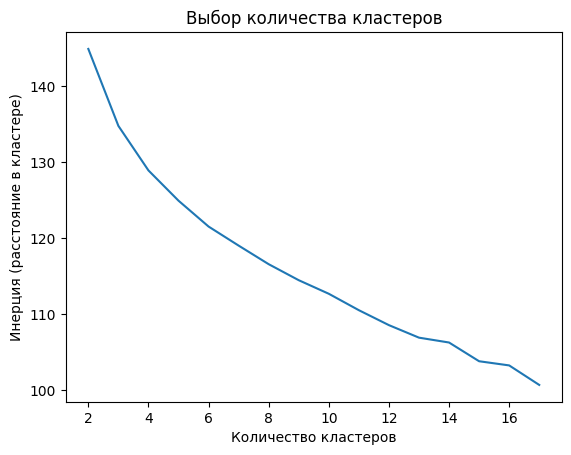

Silhouette score, полученный с помощью кластеризации K-means = 0.097



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


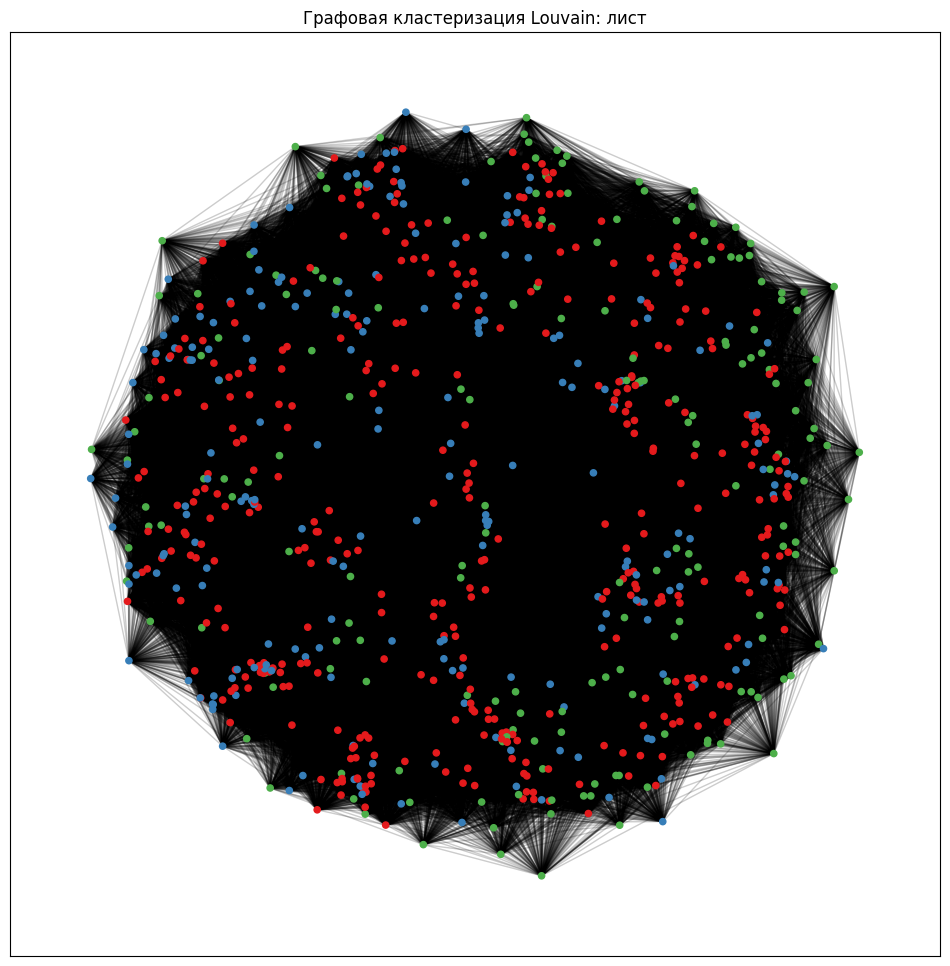

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.095

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -9.351

Найденные моделью LDA скрытые темы:
Тема 0 : 0.093*"лист" + 0.051*"вал" + 0.032*"вырвать" + 0.023*"дождь" + 0.020*"больший" + 0.015*"этюд" + 0.015*"река" + 0.014*"увядший" + 0.013*"крепиться" + 0.013*"баллада"
Тема 1 : 0.213*"лист" + 0.069*"бумага" + 0.029*"чистый" + 0.019*"лежать" + 0.014*"играть" + 0.012*"трепетать" + 0.011*"белый" + 0.010*"время" + 0.009*"взять" + 0.009*"стол"
Тема 2 : 0.194*"лист" + 0.016*"жёлтый" + 0.012*"дерево" + 0.010*"чтение" + 0.009*"читать" + 0.009*"концерт" + 0.008*"человек" + 0.008*"нести" + 0.008*"заметить" + 0.008*"нога"
Тема 3 : 0.194*"лист" + 0.015*"дерево" + 0.013*"осенний" + 0.012*"держать" + 0.011*"пожухлый" + 0.010*"увидеть" + 0.009*"количество" + 0.008*"последний" + 0.008*"исписать" + 0.008*"человек"
Тема 4 : 0.132*"лист" + 0.025*"место" + 0.022*"вариация" + 0

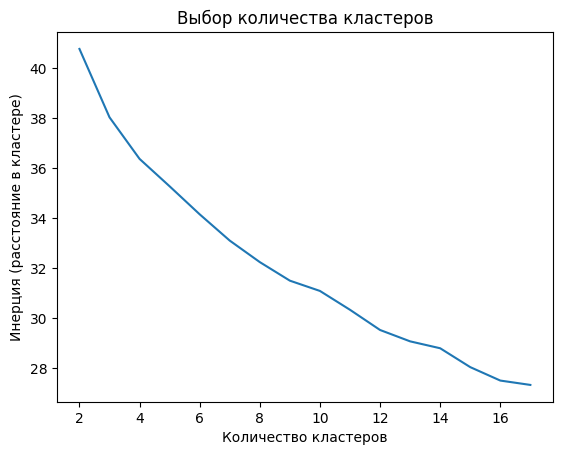

Silhouette score, полученный с помощью кластеризации K-means = 0.093



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


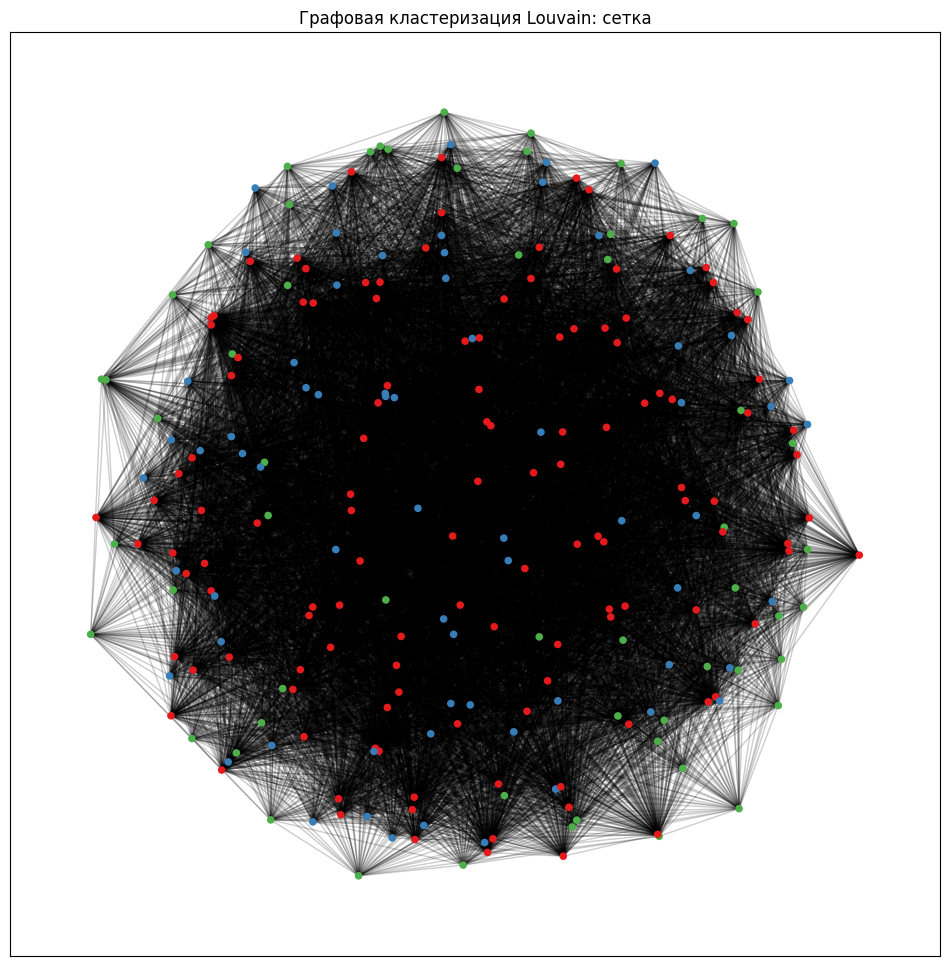

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.072

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -9.298

Найденные моделью LDA скрытые темы:
Тема 0 : 0.149*"сетка" + 0.016*"сѣтка" + 0.013*"проволочный" + 0.013*"белый" + 0.008*"покрыть" + 0.008*"волосяной" + 0.007*"клетка" + 0.007*"прозрачный" + 0.007*"мелкий" + 0.006*"снег"
Тема 1 : 0.111*"сетка" + 0.039*"сѣткать" + 0.030*"лицо" + 0.016*"частый" + 0.015*"чёрный" + 0.013*"маленький" + 0.013*"сѣтка" + 0.011*"волос" + 0.011*"тонкий" + 0.011*"красный"
Тема 2 : 0.152*"сетка" + 0.022*"напряжение" + 0.012*"перепел" + 0.010*"надевать" + 0.010*"контур" + 0.009*"платье" + 0.009*"нить" + 0.008*"лучок" + 0.007*"круглый" + 0.007*"живой"
Тема 3 : 0.187*"сетка" + 0.011*"металлический" + 0.008*"голова" + 0.006*"кровать" + 0.006*"зелёный" + 0.006*"казаться" + 0.006*"частый" + 0.006*"синий" + 0.006*"запутаться" + 0.005*"носить"
Тема 4 : 0.170*"сетка" + 0.024*"лампа" + 

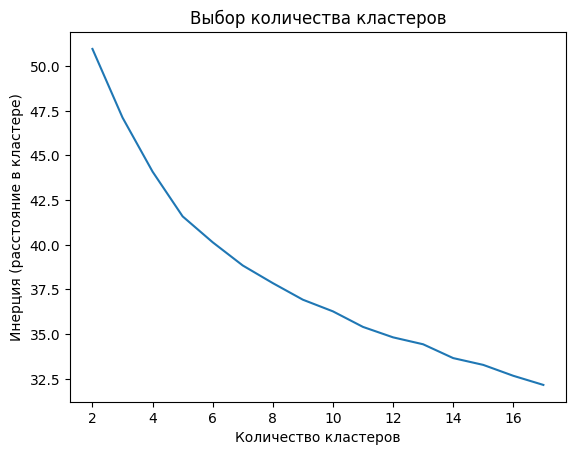

Silhouette score, полученный с помощью кластеризации K-means = 0.148



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


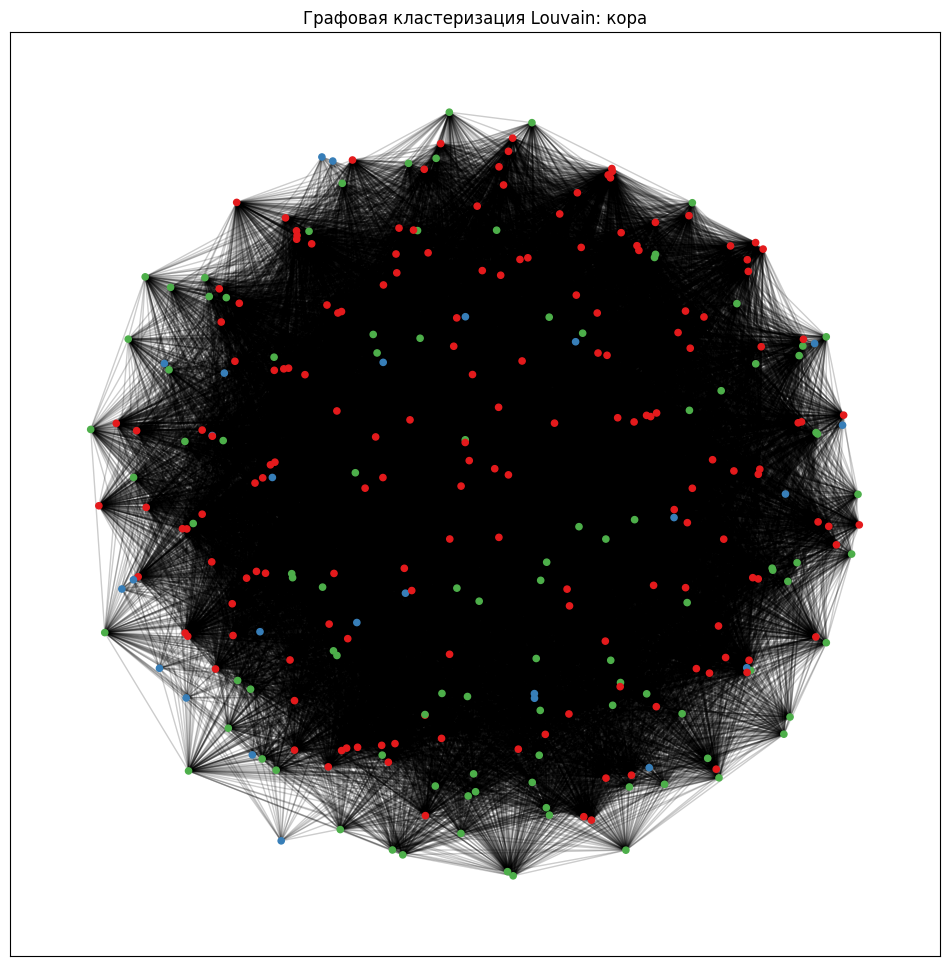

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.176

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -8.474

Найденные моделью LDA скрытые темы:
Тема 0 : 0.134*"кора" + 0.023*"земной" + 0.016*"дерево" + 0.008*"красный" + 0.007*"вода" + 0.007*"дубовый" + 0.006*"тёмный" + 0.005*"ольховый" + 0.005*"множество" + 0.005*"внутри"
Тема 1 : 0.120*"кора" + 0.027*"кор" + 0.024*"древесный" + 0.012*"земной" + 0.010*"покрыться" + 0.009*"соб" + 0.009*"тонкий" + 0.009*"внутренний" + 0.006*"толстый" + 0.006*"сделать"
Тема 2 : 0.159*"кора" + 0.028*"дерево" + 0.019*"древесный" + 0.008*"наружный" + 0.008*"питаться" + 0.007*"кожа" + 0.007*"мозг" + 0.006*"дуб" + 0.006*"пища" + 0.005*"лист"
Тема 3 : 0.114*"кора" + 0.041*"ледяной" + 0.016*"грубый" + 0.012*"подъ" + 0.012*"берёзовый" + 0.009*"покрывать" + 0.009*"отъ" + 0.008*"снег" + 0.007*"покрыть" + 0.006*"душа"
Тема 4 : 0.154*"кора" + 0.041*"земной" + 0.008*"иной" + 0.008*"врем

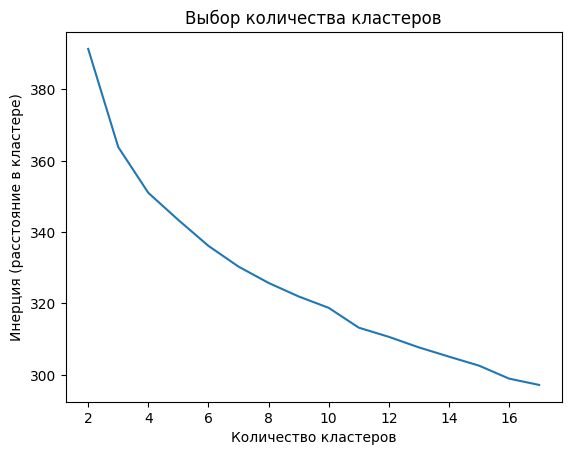

Silhouette score, полученный с помощью кластеризации K-means = 0.084



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


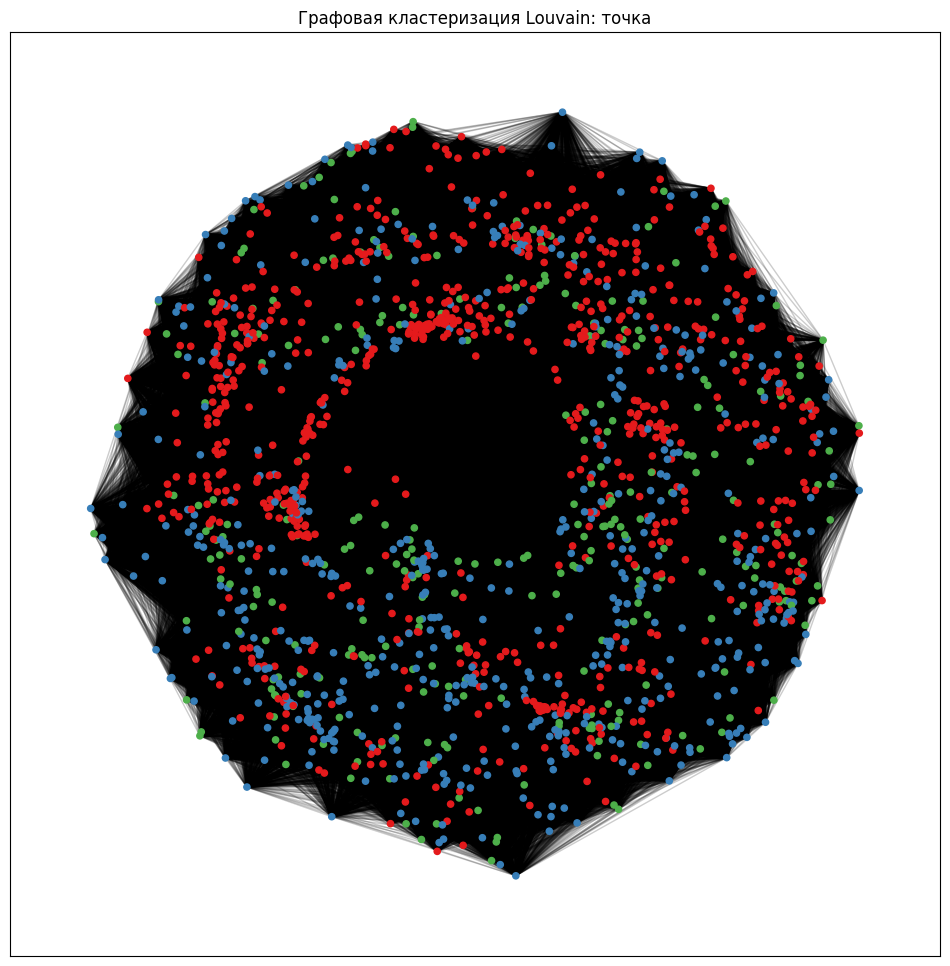

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.163

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -9.131

Найденные моделью LDA скрытые темы:
Тема 0 : 0.187*"точка" + 0.101*"зрение" + 0.018*"совершенно" + 0.014*"научный" + 0.012*"чисто" + 0.012*"линия" + 0.010*"дать" + 0.010*"история" + 0.009*"белый" + 0.009*"искусство"
Тема 1 : 0.208*"точка" + 0.108*"зрение" + 0.022*"смотреть" + 0.017*"ставить" + 0.009*"сила" + 0.009*"иной" + 0.008*"политический" + 0.007*"значение" + 0.006*"тире" + 0.006*"новый"
Тема 2 : 0.093*"точка" + 0.039*"стоить" + 0.024*"определённый" + 0.023*"вполне" + 0.022*"знать" + 0.022*"взгляд" + 0.016*"автор" + 0.014*"подойти" + 0.014*"необходимый" + 0.013*"зрение"
Тема 3 : 0.202*"точка" + 0.066*"зрение" + 0.023*"глаз" + 0.016*"исходный" + 0.012*"русский" + 0.010*"место" + 0.008*"маленький" + 0.008*"военный" + 0.007*"система" + 0.007*"чёрный"
Тема 4 : 0.176*"точка" + 0.035*"опора" + 0.030

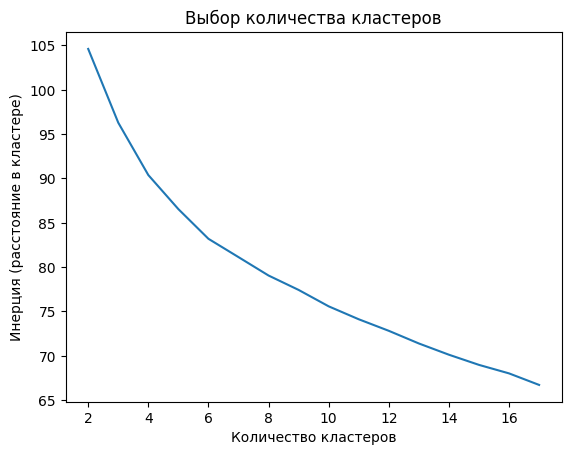

Silhouette score, полученный с помощью кластеризации K-means = 0.120



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


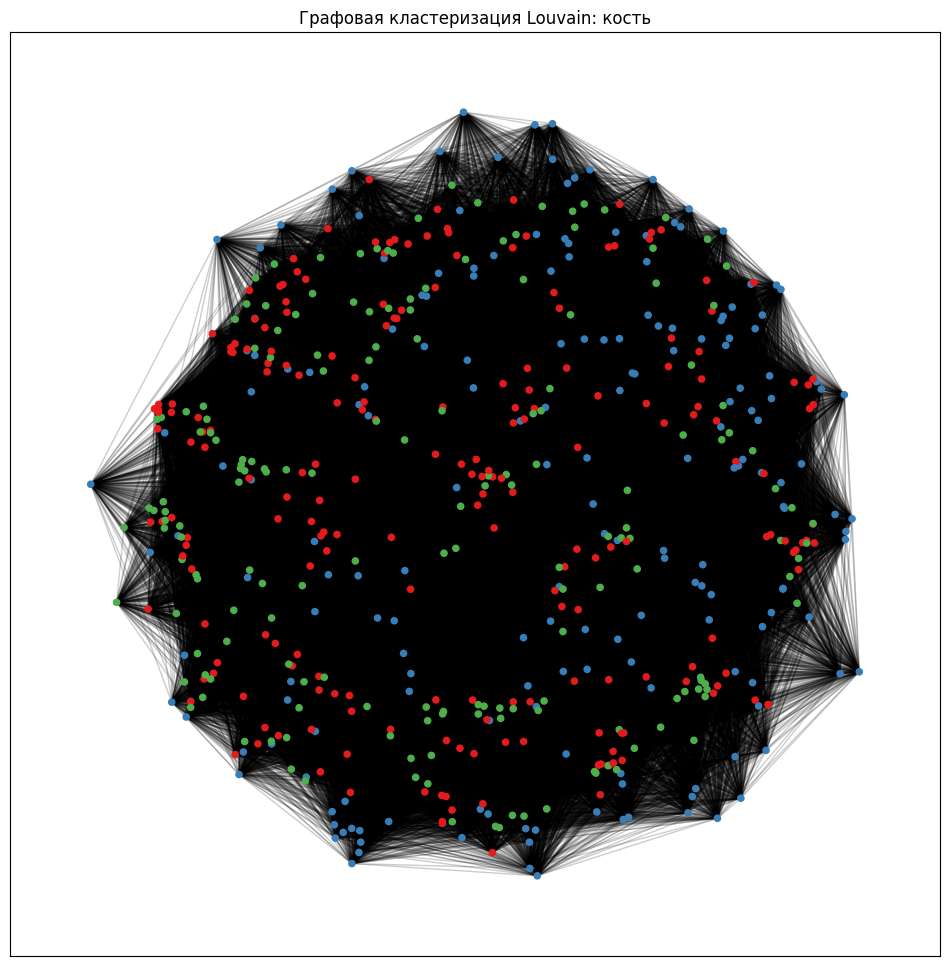

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.089

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -10.361

Найденные моделью LDA скрытые темы:
Тема 0 : 0.153*"кость" + 0.018*"переломать" + 0.018*"голова" + 0.018*"разный" + 0.015*"лежать" + 0.015*"гроб" + 0.014*"больший" + 0.013*"бросить" + 0.013*"истлеть" + 0.013*"поле"
Тема 1 : 0.202*"кость" + 0.029*"старый" + 0.017*"земля" + 0.013*"ворон" + 0.011*"сложить" + 0.011*"время" + 0.011*"игра" + 0.010*"раздробить" + 0.009*"пуля" + 0.009*"взять"
Тема 2 : 0.183*"кость" + 0.029*"человеческий" + 0.023*"промокнуть" + 0.016*"говорить" + 0.015*"слоновый" + 0.012*"сделать" + 0.011*"стол" + 0.010*"живой" + 0.009*"знать" + 0.009*"груда"
Тема 3 : 0.236*"кость" + 0.052*"плоть" + 0.044*"кожа" + 0.021*"отъ" + 0.021*"чёрный" + 0.020*"нога" + 0.015*"лицо" + 0.009*"могила" + 0.008*"мясо" + 0.008*"множество"
Тема 4 : 0.195*"кость" + 0.019*"человек" + 0.015*"место" + 0.013*"м

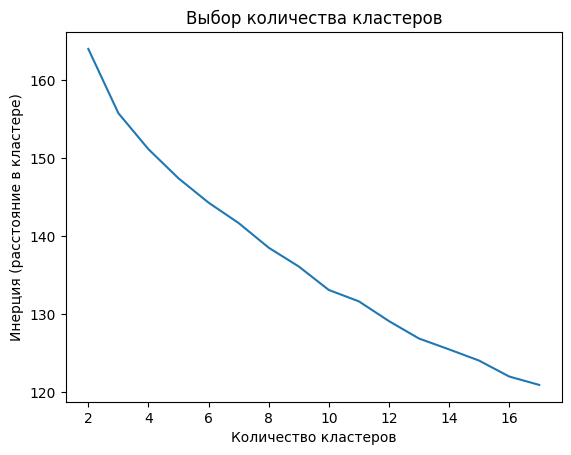

Silhouette score, полученный с помощью кластеризации K-means = 0.046



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


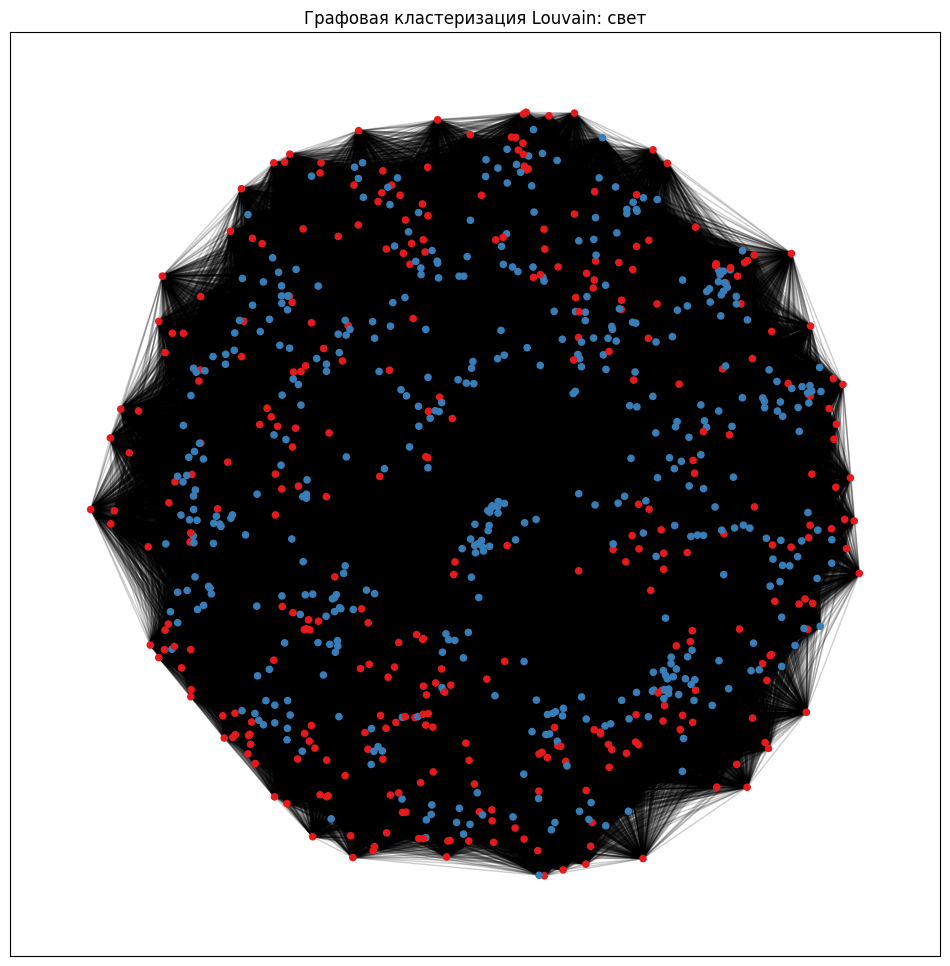

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.147

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -8.778

Найденные моделью LDA скрытые темы:
Тема 0 : 0.183*"свет" + 0.029*"человек" + 0.028*"конец" + 0.022*"выходить" + 0.018*"создать" + 0.018*"знакомый" + 0.018*"крупный" + 0.017*"новый" + 0.017*"мода" + 0.014*"белый"
Тема 1 : 0.153*"свет" + 0.022*"дух" + 0.022*"поскольку" + 0.021*"представать" + 0.021*"империя" + 0.020*"очищение" + 0.020*"радость" + 0.012*"рождение" + 0.011*"записка" + 0.011*"никак"
Тема 2 : 0.181*"свет" + 0.025*"часть" + 0.017*"быстро" + 0.017*"прежде" + 0.017*"свобода" + 0.017*"качество" + 0.016*"сменяться" + 0.015*"хороший" + 0.013*"выключить" + 0.012*"смирение"
Тема 3 : 0.208*"свет" + 0.015*"русский" + 0.014*"сидеть" + 0.013*"сей" + 0.013*"нравственный" + 0.012*"богослов" + 0.012*"догмат" + 0.012*"гертруда" + 0.010*"идти" + 0.009*"человек"
Тема 4 : 0.160*"свет" + 0.040*"благодаря" 

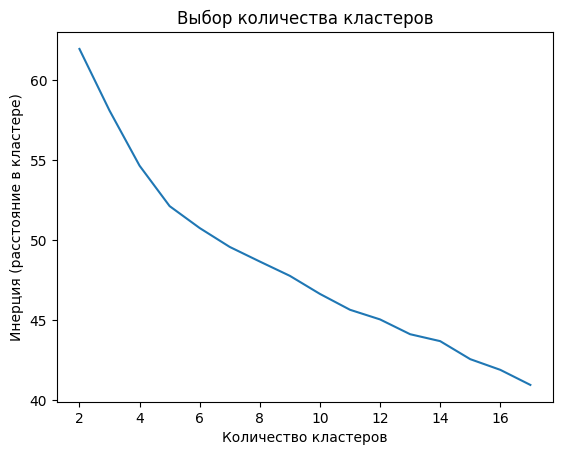

Silhouette score, полученный с помощью кластеризации K-means = 0.077



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


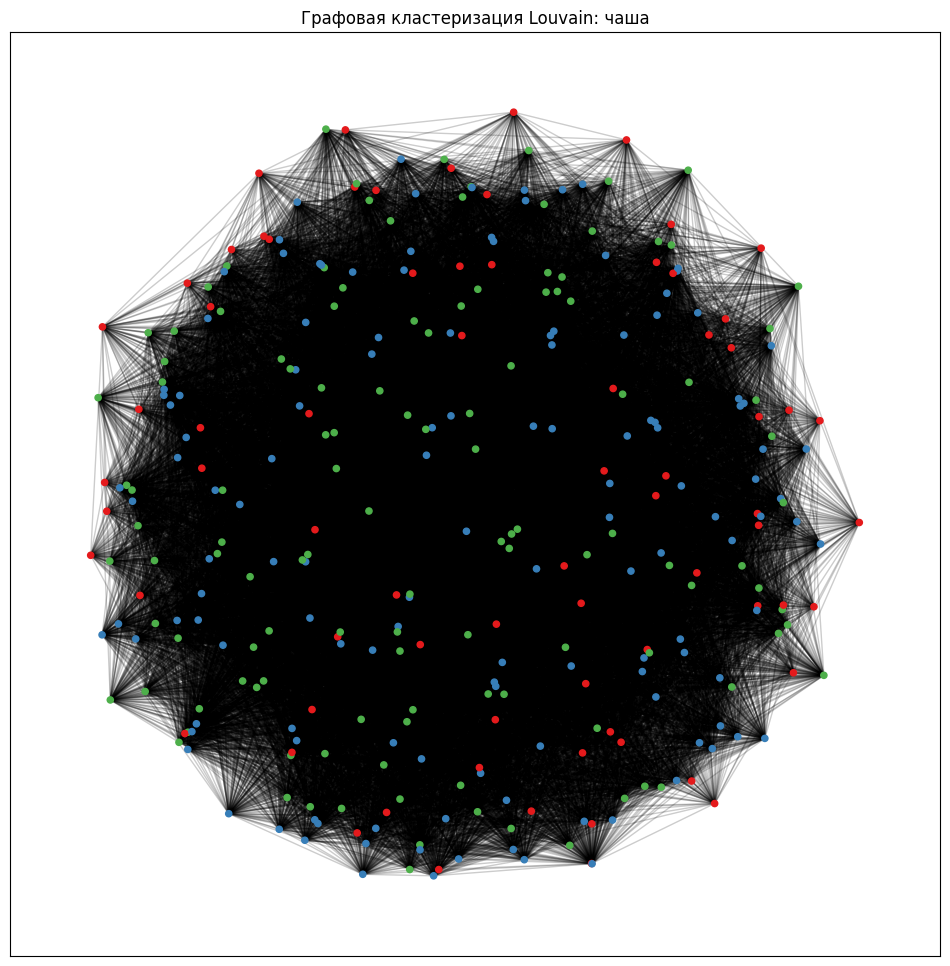

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.111

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -8.212

Найденные моделью LDA скрытые темы:
Тема 0 : 0.124*"чаша" + 0.018*"переполнить" + 0.018*"капля" + 0.015*"жизнь" + 0.012*"последний" + 0.008*"полный" + 0.007*"выпить" + 0.006*"падать" + 0.005*"вес" + 0.005*"хозяин"
Тема 1 : 0.118*"чаша" + 0.015*"вес" + 0.011*"стоять" + 0.011*"золотой" + 0.009*"пить" + 0.008*"принести" + 0.007*"ангел" + 0.007*"блаженство" + 0.007*"вылить" + 0.006*"выпить"
Тема 2 : 0.169*"чаша" + 0.009*"вода" + 0.009*"больший" + 0.007*"край" + 0.007*"вес" + 0.006*"вино" + 0.006*"рука" + 0.005*"уста" + 0.005*"наполнить" + 0.005*"выпить"
Тема 3 : 0.169*"чаша" + 0.027*"сей" + 0.016*"рука" + 0.015*"миновать" + 0.015*"серебряный" + 0.015*"испить" + 0.014*"горький" + 0.010*"вино" + 0.010*"хлеб" + 0.010*"выпить"
Тема 4 : 0.104*"чаша" + 0.014*"горечь" + 0.013*"мёртвый" + 0.009*"полный" + 0.00

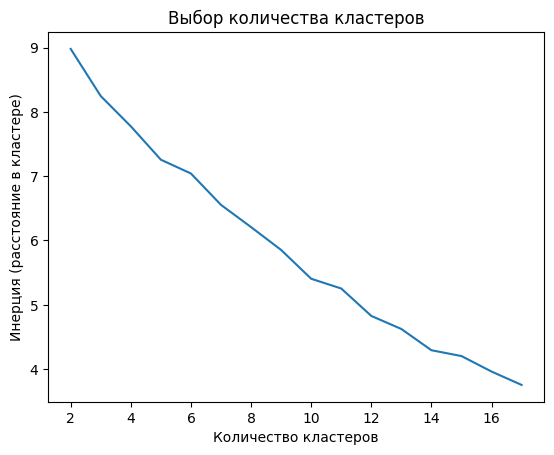

Silhouette score, полученный с помощью кластеризации K-means = 0.110



C:\Users\ryabo\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


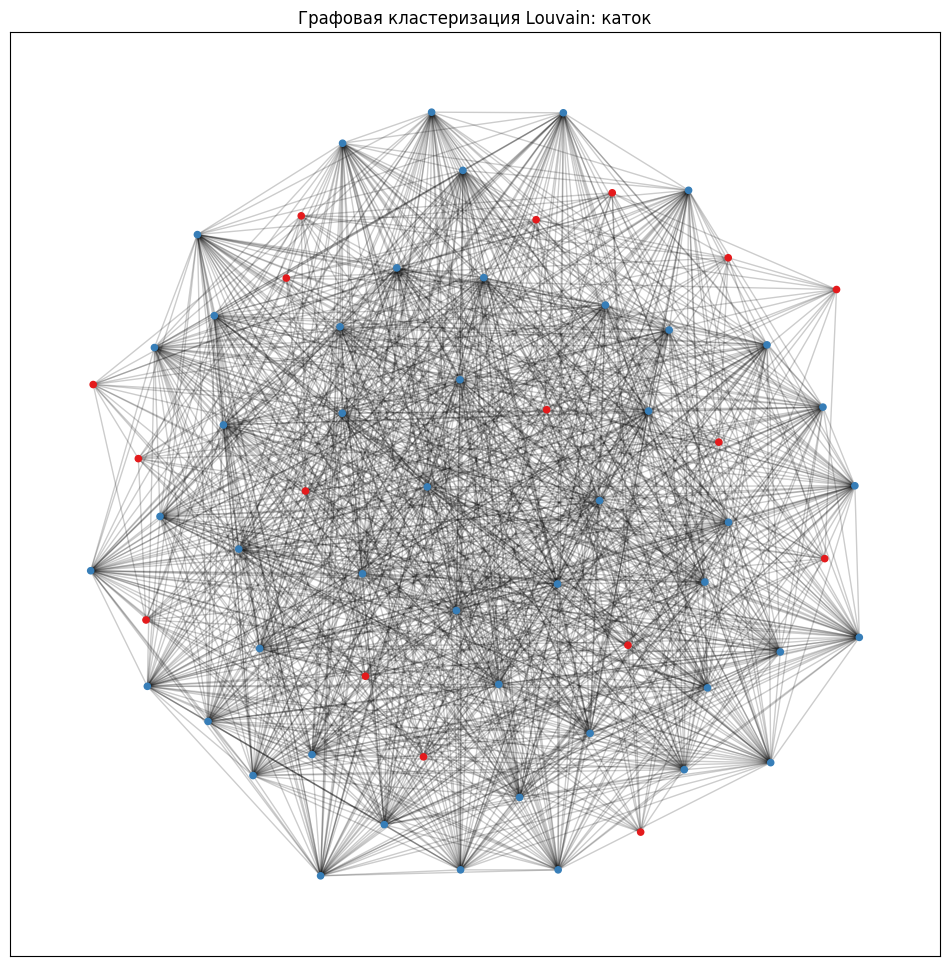

Silhouette score, полученный с помощью алгоритма Louvain, обнаруживающего сообщества = 0.090

Логарифмическая перплексия, полученная после тематического моделирования с помощью LDA = -8.593

Найденные моделью LDA скрытые темы:
Тема 0 : 0.108*"каток" + 0.010*"укатывать" + 0.009*"русский" + 0.008*"гора" + 0.008*"длина" + 0.007*"ихъ" + 0.006*"укатываютъ" + 0.006*"деревяннымъ" + 0.005*"кататься" + 0.005*"идти"
Тема 1 : 0.156*"каток" + 0.017*"сделать" + 0.013*"пойти" + 0.011*"дать" + 0.009*"хороший" + 0.008*"час" + 0.005*"устроить" + 0.005*"бегать" + 0.005*"снег" + 0.005*"сидеть"
Тема 2 : 0.117*"каток" + 0.027*"катокъ" + 0.016*"гора" + 0.011*"ледяной" + 0.008*"публика" + 0.008*"впрягаться" + 0.008*"раздаваться" + 0.008*"помогать" + 0.008*"катать" + 0.006*"отправиться"
Тема 3 : 0.128*"каток" + 0.014*"играть" + 0.013*"борона" + 0.013*"гладкий" + 0.009*"говорить" + 0.009*"вал" + 0.009*"праздник" + 0.009*"едва" + 0.008*"ледяной" + 0.007*"особенный"
Тема 4 : 0.114*"каток" + 0.014*"сад" + 0.010*"

In [22]:
cycle_by_key_words(key_words, model_tiny, prerpocessing = True)

In [32]:
key_words = ['игла', 'каток', 'лист']
for key_word in key_words:
    df = get_df(key_word)
    print(f'Анализируем pmi по ключевому слову : {key_word}\n')
    print(f'pmi, рассчитанный вручную по биграммам \n')
    single_counter, pair_counter, preprocessing_data = get_counters_and_pre_data_bigrams(df)
    show_pmi(pair_counter, single_counter)
    print(f'pmi, рассчитанный вручную по всем парам \n')
    single_counter, pair_counter, preprocessing_data = get_counters_and_pre_data_all_pairs(df)
    show_pmi(pair_counter, single_counter)
    print(f'pmi, рассчитанный вручную по парам только с ключевым словом \n')
    single_counter, pair_counter, preprocessing_data = get_counters_and_pre_data(df)
    show_pmi(pair_counter, single_counter)

    print(f'pmi, рассчитанный nlkt по биграммам from_documents (окно 2) \n')
    data = get_pairs_from_documents(preprocessing_data)
    for (word1, word2), pmi_value in data:
        if pmi_value > 3:
            print(f"({word1}', '{word2}') : {pmi_value:.2f}")
    print(f'pmi, рассчитанный nlkt по биграммам from_words (окно 3) \n')
    data = get_pairs_from_words(preprocessing_data)
    for (word1, word2), pmi_value in data:
        if pmi_value > 3:
            print(f"({word1}', '{word2}') : {pmi_value:.2f}")
    print('\n****\n')

Анализируем pmi по ключевому слову : игла

pmi, рассчитанный вручную по биграммам 

pmi = 8.06 у пары ('яйцо', 'яйцо') : 11
pmi = 6.59 у пары ('правый', 'рука') : 6
pmi = 5.65 у пары ('сосновый', 'иголый') : 5
pmi = 8.51 у пары ('солнечный', 'луч') : 6
pmi = 8.59 у пары ('светлый', 'адмиралтейский') : 10
pmi = 3.33 у пары ('тонкий', 'острый') : 11
pmi = 7.99 у пары ('морской', 'ёж') : 9
pmi = 3.71 у пары ('длинный', 'тонкий') : 10
pmi = 9.89 у пары ('слезть', 'нефтяной') : 6
pmi = 10.55 у пары ('ракетный', 'комплекс') : 6
pmi = 10.44 у пары ('клетка', 'культивировать') : 6
pmi = 9.83 у пары ('содержать', 'сыворотка') : 6
pmi = 10.95 у пары ('сыворотка', 'эмбрион') : 5
pmi = 11.36 у пары ('зенитный', 'ракетный') : 5
pmi = 10.68 у пары ('петропавловский', 'крепость') : 14
pmi = 9.06 у пары ('молодой', 'трава') : 7
pmi = 7.39 у пары ('впиваться', 'лицо') : 6


pmi, рассчитанный вручную по всем парам 

pmi = 6.30 у пары ('яйцо', 'яйцо') : 11
pmi = 4.82 у пары ('правый', 'рука') : 6
pmi = 1